In [ ]:
#https://colab.research.google.com/drive/1hownP4pc1_7kzF3NorXFd3A5fLguKlEh?authuser=4#scrollTo=generous-plumbing
#https://colab.research.google.com/drive/1hownP4pc1_7kzF3NorXFd3A5fLguKlEh
#1 preprocesing (resample to 128x128x32)! or other sizes or 48
#2 document stuff
#3 modify the diceloss!
#4 augmentation?
#5 same for AAA-DICOM?jnf

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True) #image size of 192 may work?

Mounted at /content/gdrive/


In [ ]:
#installations
#!pip install --quiet torch==1.9 #this installation must be first; fixes GPU OOM Issue #1.9.0+cu102 #also reduces RAM usage
!pip install --quiet unet #https://github.com/fepegar/unet Nov 24, 2021
!pip install --quiet torchio #0.18.73
!pip install --quiet ctviewer
!pip install --quiet monai
!pip install --quiet seaborn

     |████████████████████████████████| 172 kB 4.4 MB/s 
     |████████████████████████████████| 52.8 MB 237 kB/s 
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
#imports
import enum, time, random, multiprocessing, os
import pandas as pd
from pathlib import Path
import torch
try:
    assert(torch.cuda.is_available())
except:
    print("CUDA not available.")
#import torchvision
import torchio as tio
import torch.nn.functional as F
from unet import UNet
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
import SimpleITK as sitk
import glob
import datetime
from datetime import datetime
from ctviewer import CTViewer
import shutil
import torch.nn as nn
import random
import json
import monai
import seaborn as sns
from IPython.display import display
seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'png'
num_workers = 1
#torch version 1.9.0+cu102
print('Torch version:', torch.__version__)
print('TorchIO version:', tio.__version__) #0.18.20
#device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

CUDA not available.
Torch version: 1.12.1+cu113
TorchIO version: 0.18.84
cpu


In [ ]:
#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#specify the DiceLoss
class DICELoss(nn.Module):
      def __init__(self, weight=None, size_average=True):
          super(DICELoss, self).__init__()

      def forward(self, output, mask, eps=1e-8):
          """
          The output layer of Kilgore's 3D-UNet implementation is a LeakyReLU.
          We need to apply a sigmoid activation to the model output in order to
          constrain the target value between 0 and 1.
          See source code (Line 243):
          https://github.com/kilgore92/PyTorch-UNet/blob/master/src/unet/blocks.py#L243
          """

          output = torch.sigmoid(output)
          
          output = output.view(-1)
          mask = mask.view(-1)
          
          intersection = (output * mask).sum()                            
          dice_coeff = (2.*intersection + eps)/(output.sum() + mask.sum() + eps)  

          dice_loss = 1 - dice_coeff

          return dice_loss

#init parameters
#CHANNELS_DIMENSION = train_params['CHANNELS_DIMENSION']
#SPATIAL_DIMENSIONS = train_params['SPATIAL_DIMENSIONS']

#Action
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

#prepare te batch
def prepare_batch(batch, device):
    inputs = batch['image'][tio.DATA].to(device)
    targets = batch['segmentation'][tio.DATA].to(device)
    return inputs, targets

#dic score (not used later)
#def get_dice_score(output, target, epsilon=1e-9):
#    p0 = output
#    g0 = target
#    p1 = 1 - p0
#    g1 = 1 - g0
#    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
#    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
#    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
#    num = 2 * tp
#    denom = 2 * tp + fp + fn + epsilon
#    dice_score = num / denom
#    return dice_score

#dice loss (not used later)
#def get_dice_loss(output, target):
#    return 1 - get_dice_score(output, target)

#get model and optimizer (AdamW) can also specy pretrained weights
def get_model_and_optimizer(train_params, device, model_weights = None):
    model = UNet(
        in_channels = train_params['model_params']['in_channels'],
        out_classes = train_params['model_params']['out_classes'],
        dimensions = train_params['model_params']['dimensions'],
        num_encoding_blocks = train_params['model_params']['num_encoding_blocks'],
        out_channels_first_layer = train_params['model_params']['out_channels_first_layer'],
        normalization = train_params['model_params']['normalization'],
        upsampling_type = train_params['model_params']['upsampling'],
        residual = train_params['model_params']['residual'],
        activation = train_params['model_params']['activation'],
        padding = train_params['model_params']['padding']
        ).to(device)
    #if weights are none
    if model_weights is not None:
        checkpoint = torch.load(model_weights)
        model.load_state_dict(checkpoint)
    #optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=train_params['lr'])
    #return
    return model, optimizer

#run a single epoch
def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            #the loss function was changed
            batch_loss = criterion(logits, targets)
            #batch_loss = criterion(logits, targets)
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

#for a single epoch
def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem, try_resume = False):

    with open(os.path.join(model_dir,f'{weights_stem}_training_log_{num_epochs}_epochs.csv'),'a+') as fd:
      if try_resume == False:
        fd.write('time,epoch,train_loss,val_loss\n')

    try: num_epochs_trained = model.num_epochs_trained
    except: num_epochs_trained = 0
    
    train_losses = []
    val_losses = []
    
    # Get a baseline loss on the validation set before training
    if num_epochs_trained == 0:
        val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))

    for epoch_idx in range(1 + num_epochs_trained, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), os.path.join(model_dir,f'{weights_stem}_epoch_{epoch_idx}.pth'))

        with open(os.path.join(model_dir,f'{weights_stem}_training_log.csv'),'a+') as fd:
            mean_train = np.array(train_losses[-1])[1].mean()
            mean_val = np.array(val_losses[-1])[1].mean()
            fd.write(f'{time.time()},{epoch_idx},{mean_train},{mean_val}\n')

        with open(os.path.join(model_dir,f'{weights_stem}_training_log_{num_epochs}_epochs.csv'),'a+') as fd:
            fd.write(f'{time.time()},{epoch_idx},{mean_train},{mean_val}\n')

        #save the train params file after every epoch
        train_params['epochs_trained'] = epoch_idx
        save_params(train_params, train_params['save_path']+ 'train_params.json')

    return np.array(train_losses), np.array(val_losses)

#visualize one specific image (cannot superimpose mask as of yet)
def visualize_specific_image(row, im_type):
  image = sitk.GetArrayFromImage(sitk.ReadImage(row[im_type]))
  CTViewer(image)
  plt.show()

#image resampling
def resample_image_standardize(itk_image, out_size = (128,128,64), is_label = False):
  original_spacing = itk_image.GetSpacing()
  original_size = itk_image.GetSize()
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1]),
                 original_size[2] * (original_spacing[2] / out_size[2])]

  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  #resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
  if is_label:
      resample.SetInterpolator(sitk.sitkNearestNeighbor)
  else:
      resample.SetInterpolator(sitk.sitkBSpline)
  return resample.Execute(itk_image)

def resample(image_paths, save_path, label):
  #init
  z = sitk.NormalizeImageFilter()
  if os.path.isdir(save_path) == False:
    os.mkdir(save_path)
  #iterate
  for image_path in image_paths:
    image = sitk.ReadImage(image_path)
    image = resample_image_standardize(image, is_label = label)
    patient = image_path.rpartition('/')[2]
    if label == False:
      image = z.Execute(image)
      new_image = sitk.Cast(image, sitk.sitkFloat32) #very important that this is Float32/Float64 will not work --> Double
      new_image.CopyInformation(image)
    else:
      new_image = image
    sitk.WriteImage(new_image, save_path + patient)
    #sitkFloat32

#specify the loss
def get_loss(train_params):
  #generalized dice loss
  if train_params['loss'] == 'GDL':
    loss = monai.losses.GeneralizedDiceLoss(include_background = True, softmax = True, to_onehot_y = True)
  #generalized focal dice loss (careful with the focal weight; is class specific)
  if train_params['loss'] == 'GDFL':
    loss = monai.losses.GeneralizedDiceFocalLoss(include_background = True, softmax = True, to_onehot_y = True, focal_weight = [0.1, 0.9])
  #dice loss (may not work if label not in patch?)
  if train_params['loss'] == 'DL':
    loss = monai.losses.DiceLoss(include_background = False, sigmoid = True)
  #mask specific dice loss (may not work if label not in patch?)
  if train_params['loss'] == 'MDL':
    loss = monai.losses.MaskedDiceLoss(include_background = False, sigmoid = True)
  #return
  return loss

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#function
def get_model_params(save_path, device):
  #get train params
  train_params = load_params(save_path + 'train_params.json')
  #init the model
  model = UNet(
        in_channels = train_params['model_params']['in_channels'],
        out_classes = train_params['model_params']['out_classes'],
        dimensions = train_params['model_params']['dimensions'],
        num_encoding_blocks = train_params['model_params']['num_encoding_blocks'],
        out_channels_first_layer = train_params['model_params']['out_channels_first_layer'],
        normalization = train_params['model_params']['normalization'],
        upsampling_type = train_params['model_params']['upsampling'],
        residual = train_params['model_params']['residual'],
        activation = train_params['model_params']['activation'],
        padding = train_params['model_params']['padding']
        ).to(device)
  num_epochs = train_params['epochs']
  #define the model weights
  weights_stem = 'patches'
  model_dir = train_params['save_path']
  loss_df = pd.read_csv(os.path.join(model_dir,f'{weights_stem}_training_log_{num_epochs}_epochs.csv'))
  best_epoch = int(loss_df.iloc[loss_df['train_loss'].idxmin()]['epoch'])
  epoch_paths = pd.Series(sorted(glob.glob(os.path.join(model_dir,"*.pth"))))
  best_path = epoch_paths[epoch_paths.str.count(f'_{best_epoch}.pth') > 0]
  best_path.reset_index(inplace=True, drop=True)
  bestpoint = torch.load(best_path[0])
  model.load_state_dict(bestpoint)
  print('Loading ', best_path[0])
  #send to GPU
  model.to(device)
  #return
  return train_params, model

#specify the sampler used
def get_sampler(train_params):
  if train_params['sampler'] == 'uniform':
    sampler = tio.data.UniformSampler(patch_size = train_params['patch_size'])
  if train_params['sampler'] == 'label':
    sampler = tio.data.LabelSampler(patch_size = train_params['patch_size'], label_name = 'segmentation', label_probabilities = train_params['prob_sample'])
  return sampler

#relabel for the purpose of graphing
def relabel(row, col, id, l1, l2):
  if row[col] == id:
    return l1
  else:
    return l2

#relabel for the purpose of graphing
def relabel2(row, col, id, l1):
  if row[col] == id:
    return l1
  else:
    return row[col]

#plot
def plot_results(train_params, x, y, df, hue, kind = 'box', color = 'Greys', xlabel = None, ylabel = None, yticks = [0, 0.2, 0.4, 0.6, 0.8, 1], sns_legend = False, legend = False, fsize = 15, save_name = None):
  if xlabel == None:
    xlabel = x
  if ylabel == None:
    ylabel = y
  if save_name == None:
    save_name = x + '_' + y + '.png'
  #plot
  #sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
  ax = sns.catplot(x = x, y = y, data = df, hue = hue, kind = kind, palette = sns.color_palette(color, 2), legend = sns_legend)
  plt.yticks(yticks, fontsize = fsize, fontname='Times New Roman')
  plt.ylabel(ylabel, fontsize = fsize, fontname='Times New Roman')
  plt.xticks(fontsize = fsize, fontname='Times New Roman')
  plt.xlabel(xlabel, fontsize = fsize, fontname='Times New Roman')
  if legend == True:
    plt.legend(title = 'Dataset', fontsize = fsize, title_fontsize = fsize, loc='center left', bbox_to_anchor=(1, 0.5))

  plt.savefig(train_params['save_path'] + save_name, bbox_inches="tight")
  plt.show()

#get breakdown off results
def see_results(train_params, name, df, groups, metrics):
  df_temp = df.groupby(groups)[metrics].describe().round(2)
  df_temp.to_csv(train_params['save_path'] + name)
  display(df_temp)

In [ ]:
#read in the saved pickle file
data_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_split.pkl'
df = pd.read_pickle(data_path)

In [ ]:
#save folder
save_folder = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-TorchIO-AAA-UNet-results/'
#specify a save location
folder = datetime.now().strftime("torchio-%Y-%m-%d-%H-%M") + '/'
#the save path for everything
save_path = save_folder + folder
if os.path.isdir(save_path) == False:
  os.mkdir(save_path)

In [ ]:
#model
model_params = {
    'type': 'UNet',
    'in_channels': 1,
    'out_classes': 2, #if more than one label
    'dimensions': 3,
    'num_encoding_blocks': 4,
    'out_channels_first_layer': 32,
    'normalization': 'batch',
    'upsampling': 'linear', #conv is an option?
    'residual': True,
    'activation': 'PReLU',
    'padding': True
}
#training parameters
train_params = {
    'batch_size': 2,
    'lr': 1e-4, #increase or decrease? #is the lr too high?
    'optimizer': 'AdamW',
    'weight_decay': 1e-5,
    'epochs': 30,
    'loss': 'GDL',
    'aug': True,
    'save_path': save_path, 
    'epochs_trained': 0,
    'model_type': 'patch',
    #'CHANNELS_DIMENSION': 1, #not used
    #'SPATIAL_DIMENSIONS': 1, #not used
    'patch_size': (128, 128, 64), #1
    'patch_overlap': (32, 32, 32), #16, 16, 16
    'samples_per_volume': 6, #500
    'max_queue_length': 1000, #1000
    'model_params': model_params,
    'col_image': 'Norm-CTA-256-256-64',
    'col_label': 'Mask-Wall-256-256-64',
    'data_path': data_path,
    'sampler': 'uniform',
    'prob_sample': {0:0.4, 1:0.3, 2:0.2, 2:0.1}
}
try_resume = False

In [ ]:
#pretrained model?
train_params = None
model = None
train_params, model = get_model_params('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-TorchIO-AAA-UNet-results/torchio-2022-10-29-21-01/', device)
#read in the saved pickle file
data_path = train_params['data_path']
df = pd.read_pickle(data_path)
try_resume = True

Loading  /content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-TorchIO-AAA-UNet-results/torchio-2022-10-29-21-01/patches_epoch_12.pth


In [ ]:
#used cropped dataset? native resolution?

# Obtain the training images and labels
train_image_paths = df[df['DATA'] == 'TRAIN'][train_params['col_image']].to_list()
train_label_paths = df[df['DATA'] == 'TRAIN'][train_params['col_label']].to_list()

# Obtain the test images and labels
test_image_paths = df[df['DATA'] == 'TEST'][train_params['col_image']].to_list()
test_label_paths = df[df['DATA'] == 'TEST'][train_params['col_label']].to_list()

In [ ]:
%%time
#resample(train_image_paths, '/content/train_image_paths/', label = False)
#resample(test_image_paths, '/content/test_image_paths/', label = False)
#resample(train_label_paths, '/content/train_label_paths/', label = True)
#resample(test_label_paths, '/content/test_label_paths/', label = True)
#reget the paths
#train_image_paths = sorted(glob.glob('/content/train_image_paths/*.nii.gz'))[0:2]
#train_label_paths = sorted(glob.glob('/content/train_label_paths/*.nii.gz'))[0:2]
#test_image_paths = sorted(glob.glob('/content/test_image_paths/*.nii.gz'))[0:2]
#test_label_paths = sorted(glob.glob('/content/test_label_paths/*.nii.gz'))[0:2]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs


Dataset size: 73 subjects
Dataset size: 50 subjects


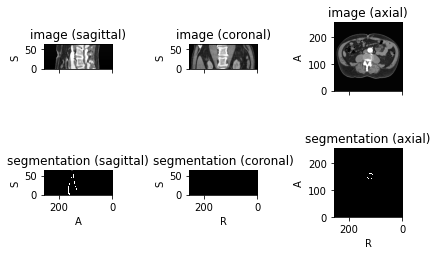

Subject(Keys: ('image', 'segmentation', 'name'); images: 2)
ScalarImage(shape: (1, 256, 256, 64); spacing: (1.87, 1.87, 2.68); orientation: LPS+; dtype: torch.FloatTensor; memory: 16.0 MiB)
LabelMap(shape: (1, 256, 256, 64); spacing: (1.87, 1.87, 2.68); orientation: LPS+; dtype: torch.ByteTensor; memory: 4.0 MiB)
Training Set: 73 subjects
Validation Set: 50 subjects


In [ ]:
#need to specify the paths for setting up the data loader
#train_image_paths/train_label_paths
#test_image_paths/test_label_paths

# Create the training set Dataloader
train_subjects = []
for i, (image_path, label_path) in enumerate(list(zip(train_image_paths, train_label_paths))):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        segmentation=tio.LabelMap(label_path),
        name=[label_path, image_path]
    )
    train_subjects.append(subject)

# Create the testing set Dataloader
test_subjects = []
for i, (image_path, label_path) in enumerate(list(zip(test_image_paths, test_label_paths))):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        segmentation=tio.LabelMap(label_path),
        name=[label_path, image_path]
    )
    test_subjects.append(subject)

  # View length of train and test datasets
train_dataset = tio.SubjectsDataset(train_subjects)
print('Dataset size:', len(train_dataset), 'subjects')

test_dataset = tio.SubjectsDataset(test_subjects)
print('Dataset size:', len(test_dataset), 'subjects')

#single subject
one_subject = test_dataset[1]
one_subject.plot()
#print
print(one_subject)
print(one_subject.image)
print(one_subject.segmentation)

#augmentation make sure to look at actual image after applying transforms!
#training_transform = tio.Compose([
    #spatial
#    tio.RandomFlip(axes = (0, 1, 2), flip_probability = 0.5),
#    tio.RandomNoise(mean = [-0.9, 0.9], std = [0.25, 0.3]),
#    tio.RandomBiasField(coefficients = [0.05, 0.6], order = 2),
    #tio.RandomAffine(scales = [0.9, 1.1], degrees = random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330])),
    # tio.ToCanonical(),
    # tio.HistogramStandardization({'image': landmarks}),
    #tio.ZNormalization(masking_method=tio.ZNormalization.mean), #unnecceasry does prior
    # tio.RandomNoise(),
    # tio.RandomFlip(),
    #tio.OneHot(),
#]) #may want to increase augmentation here

#these numbers were determined by trial-and-error to ensre image quality was not severely impacted
#spatial
spatial_transforms = {
    tio.RandomFlip(axes = (0, 1, 2), flip_probability = 1),
}
#noise
noise_transforms = {
    tio.RandomNoise(mean = [-0.9, 0.9], std = [0.05, 0.3]),
    }
#intensity
intensity_transforms = {
    tio.RandomBiasField(coefficients = [0.05, 0.6], order = 2)
}
#compose
#augmentation make sure to look at actual image after applying transforms!
training_transform = tio.Compose([
    tio.ZNormalization(),
    tio.OneOf(spatial_transforms, p=0.5),
    tio.OneOf(noise_transforms, p=0.5),
    tio.OneOf(intensity_transforms, p=0.5),
    
])
training_transform_no_aug = tio.Compose([
    tio.ZNormalization(), 
])

#seperate
training_subjects, validation_subjects = train_dataset, test_dataset

if train_params['aug']:
  #augmentation
  training_set = tio.SubjectsDataset(training_subjects, transform=training_transform)
else:
  #no augmentation
  training_set = tio.SubjectsDataset(training_subjects)

#no augmentation
validation_set = tio.SubjectsDataset(validation_subjects)
#print
print('Training Set:', len(training_set), 'subjects')
print('Validation Set:', len(validation_set), 'subjects')

#specify the training parameters
training_batch_size = train_params['batch_size']
validation_batch_size = train_params['batch_size']
patch_size = train_params['patch_size']
samples_per_volume = train_params['samples_per_volume'] #500
max_queue_length = train_params['max_queue_length']
patch_overlap = train_params['patch_overlap']

#specify the samplers
#probabilities = {0:0.4, 1:0.3, 2:0.2, 2:0.1}
#train_sampler = tio.data.LabelSampler(patch_size = patch_size, label_name = 'segmentation', label_probabilities = probabilities)
#train_sampler = tio.data.GridSampler(training_subjects[0], patch_size = patch_size, patch_overlap = patch_overlap)
#train_sampler = tio.data.UniformSampler(patch_size = patch_size)
#get consistent with the inference 
train_sampler = get_sampler(train_params)
val_sampler = tio.data.GridSampler(validation_subjects[0], patch_size, patch_overlap) #val subject is to see how many patches (should precompute too!)


#sampler = tio.data.UniformSampler(patch_size)
#specify the patching strategy for the training set
patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=train_sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)
#specify the patching strategy for the testing set
patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=val_sampler, #this should always be Gridsamler? #https://torchio.readthedocs.io/patches/patch_training.html#
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)
#load training data
training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)
#load testig data
validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [ ]:
#directory to save model files
model_dir = train_params['save_path']
#dice loss
#criterion = DICELoss()
criterion = get_loss(train_params)
#the epochs to train for
num_epochs = train_params['epochs']
#checkpointed epochs
try_resume_epoch = train_params['epochs_trained'] #need to check this! / haven't tested for 
#loading pretrained then coninue training functionality

In [ ]:
#specify the training
if try_resume:
    # resume_model_weights = f'./checkpoints/patches_epoch_{try_resume_epoch-1}.pth'
    resume_model_weights = os.path.join(model_dir,f'patches_epoch_{try_resume_epoch}.pth') #originally -1
    model, optimizer = get_model_and_optimizer(train_params, device, model_weights=resume_model_weights)
    model.num_epochs_trained = try_resume_epoch #originally -1
else:
    model, optimizer = get_model_and_optimizer(train_params, device)
    model.num_epochs_trained = 0

weights_path = os.path.join(model_dir,f'{num_epochs}_epochs_patches_state_dict.pth')
weights_stem = 'patches'

try: os.mkdir('checkpoints')
except: pass

#train()
train_losses, val_losses = train(
    num_epochs,
    training_loader_patches,
    validation_loader_patches,
    model,
    optimizer,
    weights_stem,
    try_resume
)

#loads the best model when training has completed
loss_df = pd.read_csv(os.path.join(model_dir,f'{weights_stem}_training_log_{num_epochs}_epochs.csv'))
best_epoch = int(loss_df.iloc[loss_df['train_loss'].idxmin()]['epoch'])
epoch_paths = pd.Series(sorted(glob.glob(os.path.join(model_dir,"*.pth"))))
best_path = epoch_paths[epoch_paths.str.count(f'_{best_epoch}.pth') > 0]
best_path.reset_index(inplace=True, drop=True)
bestpoint = torch.load(best_path[0])
model, optimizer = get_model_and_optimizer(train_params, device)
model.load_state_dict(bestpoint)

#for the best?
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}

torch.save(checkpoint, weights_path)

with open(os.path.join(model_dir,f'saved_epochs.csv'),'a+') as fd:
  fd.write(f'Epoch saved from {weights_stem}_training_log_{num_epochs}_epochs.csv: {best_epoch}\n')

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)

# Loss curve for resuming training not implemented yet
if not try_resume:
    fig, ax = plt.subplots()
    plot_times(ax, train_losses, 'Training')
    plot_times(ax, val_losses, 'Validation')
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Dice loss')
    ax.set_title('Training with patches (subvolumes)')
    ax.legend()
    fig.autofmt_xdate()
else:
    fig, ax = plt.subplots()
    plot_times(ax, train_losses, 'Training')
    plot_times(ax, val_losses, 'Validation')
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Dice loss')
    ax.set_title('Training with patches (subvolumes)')
    ax.legend()
    fig.autofmt_xdate()

Starting epoch 13


  0%|          | 0/219 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


Training mean loss: 0.626


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.660
Starting epoch 14


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.611


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.647
Starting epoch 15


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.611


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.651
Starting epoch 16


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.593


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.635
Starting epoch 17


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.592


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.637
Starting epoch 18


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.588


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.645
Starting epoch 19


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.582


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.639
Starting epoch 20


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.579


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.630
Starting epoch 21


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.578


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.639
Starting epoch 22


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.567


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.621
Starting epoch 23


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.560


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.620
Starting epoch 24


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.567


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.632
Starting epoch 25


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.553


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.615
Starting epoch 26


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.561


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.642
Starting epoch 27


  0%|          | 0/219 [00:00<?, ?it/s]

Training mean loss: 0.552


  0%|          | 0/150 [00:00<?, ?it/s]

Validation mean loss: 0.613
Starting epoch 28


  0%|          | 0/219 [00:00<?, ?it/s]

In [ ]:
#get the pretrained model
#pretrained model?
train_params = None
model = None
train_params, model = get_model_params('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-TorchIO-AAA-UNet-results/torchio-2022-10-29-21-01/', device)
#read in the saved pickle file
data_path = train_params['data_path']
df = pd.read_pickle(data_path)

Loading  /content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-TorchIO-AAA-UNet-results/torchio-2022-10-29-21-01/patches_epoch_27.pth


In [ ]:
def nonsense(prediction):
  temp = np.argmax(prediction.numpy(), axis = 0) 
  temp = np.swapaxes(temp, 0, 2)
  temp_im = sitk.GetImageFromArray(temp)
  temp_im = sitk.Cast(temp_im, sitk.sitkUInt8)
  return temp_im

In [ ]:
#generate predictions
def generate_predictions(row, train_params, model, device):
  #function
  #image path
  image_path = row[train_params['col_image']]
  #label path
  label_path = row[train_params['col_label']]
  #specify dims
  CHANNELS_DIMENSION = 1
  #overlap
  #patch_overlap = 0
  #subject
  subject = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(image_path), segmentation = tio.LabelMap(label_path),)])
  #select
  subject = subject[0]
  #grid sampler
  #grid_sampler = tio.inference.GridSampler(subject, train_params['patch_size'], patch_overlap,)
  grid_sampler = tio.inference.GridSampler(subject, 
                                           train_params['patch_size'], 
                                           train_params['patch_overlap']
                                           )
  #patch loader
  patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=1)
  #aggregate
  aggregator = tio.inference.GridAggregator(grid_sampler) #by default it uses crop; use average instead? 
  #the model
  model.eval()
  #no grad
  with torch.no_grad():
    #iterate
    for patches_batch in patch_loader:
      #inputs
      inputs = patches_batch['image'][tio.DATA].to(device)
      #locations
      locations = patches_batch[tio.LOCATION]
      #prob
      probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
      #append
      aggregator.add_batch(probabilities, locations)

  #foreground
  foreground = aggregator.get_output_tensor()
  #affine
  affine = subject.image.affine
  #get the final prediction
  prediction = tio.ScalarImage(tensor=foreground, affine=affine)
  #get the sitk
  #get the sitk
  prediction_image = nonsense(prediction)
  #spacing
  original_image = sitk.ReadImage(image_path)
  #copy
  prediction_image.CopyInformation(original_image)
  #now completely revert
  clinical_image = sitk.ReadImage(row['Norm-CTA'])
  #convertl
  resampler = sitk.ResampleImageFilter()
  resampler.SetReferenceImage(clinical_image)
  resampler.SetTransform(sitk.Transform())
  resampler.SetInterpolator(sitk.sitkNearestNeighbor) #could use BSpline instead?
  prediction_image = resampler.Execute(prediction_image)
  prediction_image.CopyInformation(clinical_image)
  #return
  return save_image(train_params['save_path'], 'patch-predictions', row['Patient'], prediction_image)

In [ ]:
%%time
#30 minutes Nearest Neighbor
#21 for bspline
df['patch-predictions'] = df.apply(generate_predictions, axis = 1, args = (train_params, model, device))

/usr/local/lib/python3.7/dist-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


CPU times: user 12min 22s, sys: 11 s, total: 12min 33s
Wall time: 12min 32s


In [ ]:
#perform DSC score evaluation
def compute_metrics(gt, pred, metrics = sitk.LabelOverlapMeasuresImageFilter()):
  #compare (order matters)
  metrics.Execute(gt, pred)
  DSC = metrics.GetDiceCoefficient()
  FP = metrics.GetFalsePositiveError()
  FN = metrics.GetFalseNegativeError()
  JC = metrics.GetJaccardCoefficient()
  #gt
  #pred
  return DSC, FP, FN, JC

#get
def get_metrics(row, gt_col = 'Mask-Wall', pred_col = 'patch-predictions'):
  #read
  gt = sitk.ReadImage(row[gt_col])
  pred = sitk.ReadImage(row[pred_col])
  return compute_metrics(gt, pred)

In [ ]:
%%time
df['DSC'], df['FP'], df['FN'], df['JC'] = zip(*df.apply(get_metrics, axis = 1))
#save
df.to_pickle(train_params['save_path'] + 'df_results.pkl')

CPU times: user 43.3 s, sys: 1.55 s, total: 44.9 s
Wall time: 29.9 s


In [ ]:
#load the data
save_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-TorchIO-AAA-UNet-results/torchio-2022-10-29-21-01/'
train_params = load_params(save_path + 'train_params.json')
df = pd.read_pickle(save_path + 'df_results.pkl')

In [ ]:
#display
#apply df
df['Dataset'] = df.apply(relabel, axis = 1, args = ('DATA', 'TRAIN', 'Train', 'Test'))
df['Wall'] = df.apply(relabel2, axis = 1, args = ('Wall', 'NA', 'Asymptomatic'))

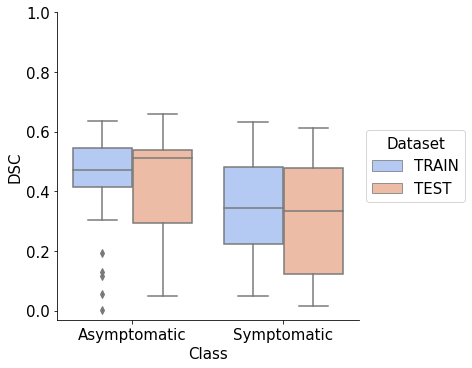

DSC                                          
                     count  mean   std   min   25%   50%   75%   max
Dataset Class                                                       
Test    Asymptomatic  25.0  0.42  0.19  0.05  0.29  0.51  0.54  0.66
        Symptomatic   25.0  0.32  0.19  0.02  0.12  0.33  0.48  0.61
Train   Asymptomatic  38.0  0.44  0.16  0.00  0.41  0.47  0.55  0.64
        Symptomatic   35.0  0.35  0.17  0.05  0.22  0.34  0.48  0.63

In [ ]:
#do plotting
plot_results(train_params, x = 'Class', y = 'DSC', df = df, hue = 'DATA', color = 'coolwarm', legend = True)
#plot all the results
see_results(train_params, 'Dataset_Class_DSC.csv', df, groups = ['Dataset', 'Class'], metrics = ['DSC'])

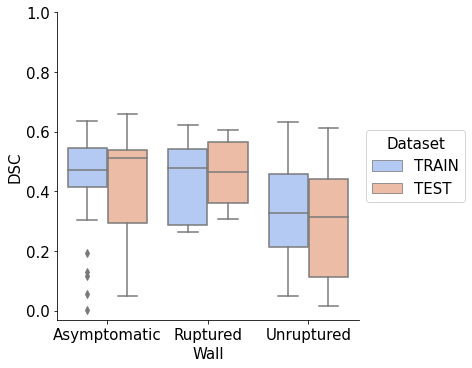

DSC                                          
                     count  mean   std   min   25%   50%   75%   max
Dataset Wall                                                        
Test    Asymptomatic  25.0  0.42  0.19  0.05  0.29  0.51  0.54  0.66
        Ruptured       4.0  0.46  0.14  0.31  0.36  0.46  0.56  0.61
        Unruptured    21.0  0.30  0.19  0.02  0.11  0.31  0.44  0.61
Train   Asymptomatic  38.0  0.44  0.16  0.00  0.41  0.47  0.55  0.64
        Ruptured       5.0  0.44  0.16  0.26  0.29  0.48  0.54  0.62
        Unruptured    30.0  0.34  0.17  0.05  0.21  0.33  0.46  0.63

In [ ]:
#do plotting
plot_results(train_params, x = 'Wall', y = 'DSC', df = df, hue = 'DATA', color = 'coolwarm', legend = True)
#plot all the results
see_results(train_params, 'Dataset_Wall_DSC.csv', df, groups = ['Dataset', 'Wall'], metrics = ['DSC'])

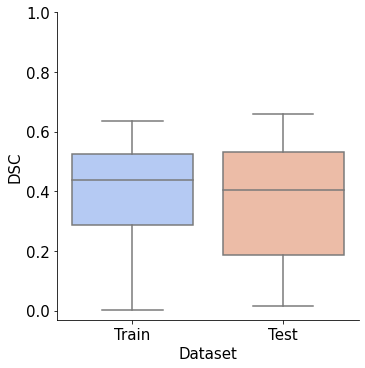

DSC                                          
        count  mean   std   min   25%   50%   75%   max
Dataset                                                
Test     50.0  0.37  0.19  0.02  0.19  0.40  0.53  0.66
Train    73.0  0.40  0.17  0.00  0.29  0.44  0.53  0.64

In [ ]:
#do plotting
plot_results(train_params, x = 'Dataset', y = 'DSC', df = df, hue = None, color = 'coolwarm', legend = False)
#plot all the results
see_results(train_params, 'Dataset_DSC.csv', df, groups = ['Dataset'], metrics = ['DSC'])

In [ ]:
#subset
df_subset = df[df['DATA'] == 'TEST'].sort_values(['DSC'], ascending = False).head(10)

In [ ]:
#select samples
row1 = df_subset.iloc[0]
row2 = df_subset.iloc[3]
row3 = df_subset.iloc[5]

In [ ]:
row1

Class                                                               Asymptomatic
Class_Label                                                                    0
Wall                                                                Asymptomatic
Wall_Label                                                                     0
Patient                                                                     U026
Norm-CTA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall                      /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-AAA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-All                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Norm-CTA-64                    /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall-64                   /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT-64                 

In [ ]:
row2

Class                                                                Symptomatic
Class_Label                                                                    1
Wall                                                                  Unruptured
Wall_Label                                                                     1
Patient                                                                     R084
Norm-CTA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall                      /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-AAA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-All                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Norm-CTA-64                    /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall-64                   /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT-64                 

In [ ]:
row3

Class                                                                Symptomatic
Class_Label                                                                    1
Wall                                                                    Ruptured
Wall_Label                                                                     2
Patient                                                                     R087
Norm-CTA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall                      /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-AAA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-All                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Norm-CTA-64                    /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall-64                   /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT-64                 

In [ ]:
row = df[df['DATA'] == 'TEST'].iloc[3]
image_path = row[train_params['col_image']]
label_path = row[train_params['col_label']]
CHANNELS_DIMENSION = 1
patch_overlap = 4
#perform inference for a single subject
subject = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(image_path), segmentation = tio.LabelMap(label_path),)])
subject = subject[0]
#subject = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(image_path),)])
#grid sampler
grid_sampler = tio.inference.GridSampler(subject, patch_size, patch_overlap,)
#patch loader
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=validation_batch_size)
#aggregate
aggregator = tio.inference.GridAggregator(grid_sampler)
#the model
model.eval()
#no grad
with torch.no_grad():
  #iterate
  for patches_batch in patch_loader:
    #inputs
    inputs = patches_batch['image'][tio.DATA].to(device)
    #locations
    locations = patches_batch[tio.LOCATION]
    #prob
    probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
    #append
    aggregator.add_batch(probabilities, locations)

#foreground
foreground = aggregator.get_output_tensor()
#affine
affine = subject.image.affine
#get the final prediction
prediction = tio.ScalarImage(tensor=foreground, affine=affine)
#visual
subject.add_image(prediction, 'prediction')
subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'RdBu_r'})

In [ ]:
#function
#image path
image_path = row[train_params['col_image']]
#label path
label_path = row[train_params['col_label']]
#specify dims
CHANNELS_DIMENSION = 1
#overlap
patch_overlap = 0
#subject
subject = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(image_path), segmentation = tio.LabelMap(label_path),)])
#select
subject = subject[0]
#grid sampler
grid_sampler = tio.inference.GridSampler(subject, train_params['patch_size'], patch_overlap,)
#grid_sampler = tio.inference.GridSampler(subject, train_params['patch_size'], train_params['patch_overlap'],)
#patch loader
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=1)
#aggregate
aggregator = tio.inference.GridAggregator(grid_sampler)
#the model
model.eval()
#no grad
with torch.no_grad():
  #iterate
  for patches_batch in patch_loader:
    #inputs
    inputs = patches_batch['image'][tio.DATA].to(device)
    #locations
    locations = patches_batch[tio.LOCATION]
    #prob
    probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
    #append
    aggregator.add_batch(probabilities, locations)

#foreground
foreground = aggregator.get_output_tensor()
#affine
affine = subject.image.affine
#get the final prediction
prediction = tio.ScalarImage(tensor=foreground, affine=affine)
#get the sitk
prediction_image = nonsense(prediction)
#now completely revert
clinical_image = sitk.ReadImage(row['Norm-CTA'])
#convertl
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(clinical_image)
resampler.SetTransform(sitk.Transform())
resampler.SetInterpolator(sitk.sitkBSpline)
prediction_image = resampler.Execute(prediction_image)
prediction_image.CopyInformation(clinical_image)
#return
#save_image(train_params['save_path'], 'patch-predictions', row['Patient'], prediction_image)